In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
df_marketing = pd.read_csv(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Portfolio Projects_storage\Day 32 - Digital Marketing Conversion Prediction\digital_marketing_campaign_dataset.csv')
df = df_marketing.copy()

In [3]:
df.head()

# Advertising Platform and Advertising Tool is redacted due to confidentiality issue

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.describe().T

# income, adspend, WebsiteVisits, PagesPerVisit, TimeOnSite, SocialShares is likely skewed to the right 
# Conversion is heavily imbalanced

,count,mean,std,min,25%,50%,75%,max
CustomerID,8000.0,11999.500000,2309.545410,8000.000000,9999.750000,11999.500000,13999.250000,15999.000000
Age,8000.0,43.625500,14.902785,18.000000,31.000000,43.000000,56.000000,69.000000
Income,8000.0,84664.196750,37580.387945,20014.000000,51744.500000,84926.500000,116815.750000,149986.000000
AdSpend,8000.0,5000.944830,2838.038153,100.054813,2523.221165,5013.440044,7407.989369,9997.914781
ClickThroughRate,8000.0,0.154829,0.084007,0.010005,0.082635,0.154505,0.228207,0.299968
ConversionRate,8000.0,0.104389,0.054878,0.010018,0.056410,0.104046,0.152077,0.199995
WebsiteVisits,8000.0,24.751625,14.312269,0.000000,13.000000,25.000000,37.000000,49.000000
PagesPerVisit,8000.0,5.549299,2.607358,1.000428,3.302479,5.534257,7.835756,9.999055
TimeOnSite,8000.0,7.727718,4.228218,0.501669,4.068340,7.682956,11.481468,14.995311
SocialShares,8000.0,49.799750,28.901165,0.000000,25.000000,50.000000,75.000000,99.000000


In [7]:
categorical_cols = ['CampaignChannel', 'Gender', 'CampaignType']

for col in categorical_cols:
    display(df[col].value_counts())

# Conversion can also be seen in the campaign type thus will be dropped during feature selection

CampaignChannel
Referral        1719
PPC             1655
Email           1557
SEO             1550
Social Media    1519
Name: count, dtype: int64

Gender
Female    4839
Male      3161
Name: count, dtype: int64

CampaignType
Conversion       2077
Awareness        1988
Consideration    1988
Retention        1947
Name: count, dtype: int64

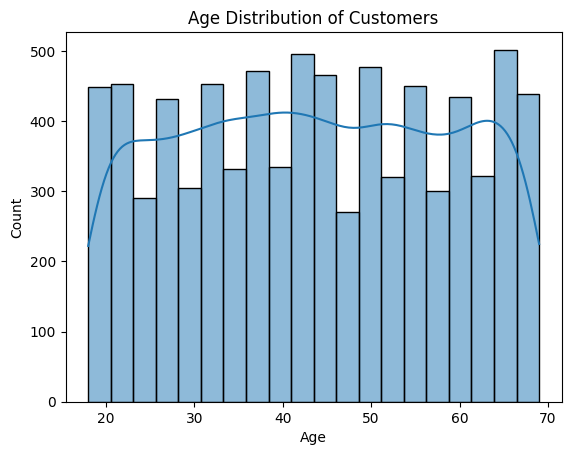

Age Skewness: -0.004916459562315591


In [8]:
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print("Age Skewness:", df['Age'].skew())


# slightly left tailed, negligible, cx age are evenly distributed around the average
# 

The customer base has two peaks - one around age 20-25 and another around age 65-70. Middle-aged customers (30-60) are less represented

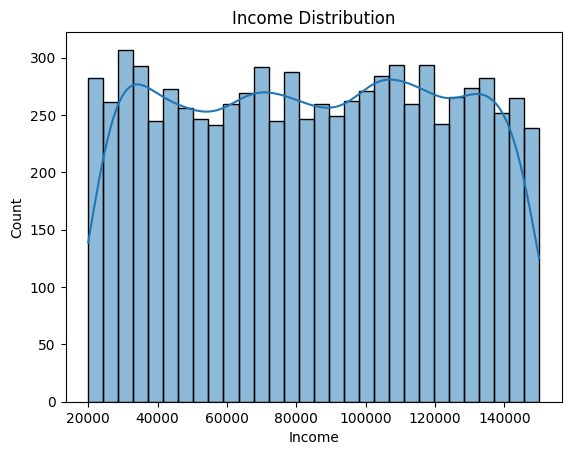

Skew: -0.01129802398913965


In [9]:
sns.histplot(df['Income'], kde = True, bins = 30)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.show()

print('Skew:', df['Income'].skew())

# slightly left tailed, negligible, cx income are evenly distributed around the average


Customers are distributed evenly across all income levels from $20,000 to $150,000. No income group is more represented than others.

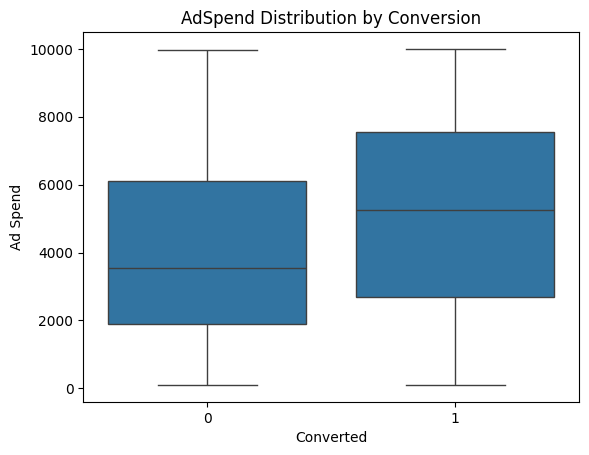

,count,mean,std,min,25%,50%,75%,max
Conversion,,,,,,,,
0,988.0,4058.398466,2684.283677,100.054813,1881.509187,3554.554979,6103.983738,9977.669768
1,7012.0,5133.750850,2834.132748,103.409243,2682.533287,5249.718686,7555.075908,9997.914781


In [10]:
sns.boxplot(x = 'Conversion',
            y = 'AdSpend',
            data = df)

plt.title('AdSpend Distribution by Conversion')
plt.xlabel('Converted')
plt.ylabel('Ad Spend')
plt.show()

df.groupby('Conversion')['AdSpend'].describe()

#Customers associated with higher advertising spend show a higher likelihood of conversion.
# Customers who converted (1) had a significantly higher and more consistent ad spend compared to those who did not convert (0)

Customers who converted received higher advertising spend. Converters also show more variation in ad spend amounts.

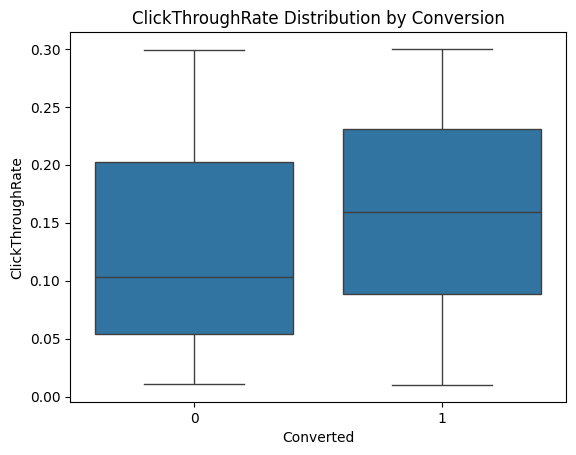

CTR and Conversion Correlation: 0.12001228447637169


In [11]:
sns.boxplot(x = 'Conversion',
            y = 'ClickThroughRate',
            data = df)

plt.title('ClickThroughRate Distribution by Conversion')
plt.xlabel('Converted')
plt.ylabel('ClickThroughRate')
plt.show()

ctr_conv_corr = df[['ClickThroughRate', 'Conversion']].corr().iloc[0, 1]
print(f'CTR and Conversion Correlation: {ctr_conv_corr}')

# Correlation is positive (0.12) → weak but meaningful
# Suggests that higher CTR slightly improves conversion probability
# CTR and Conversion move in the same direction — ads that get clicked more are a bit more likely to lead to conversions. However, the relationship is not strong, so you’ll want to combine CTR with engagement factors (like time on site or email clicks

Customers who converted have higher click-through rates on advertisements.

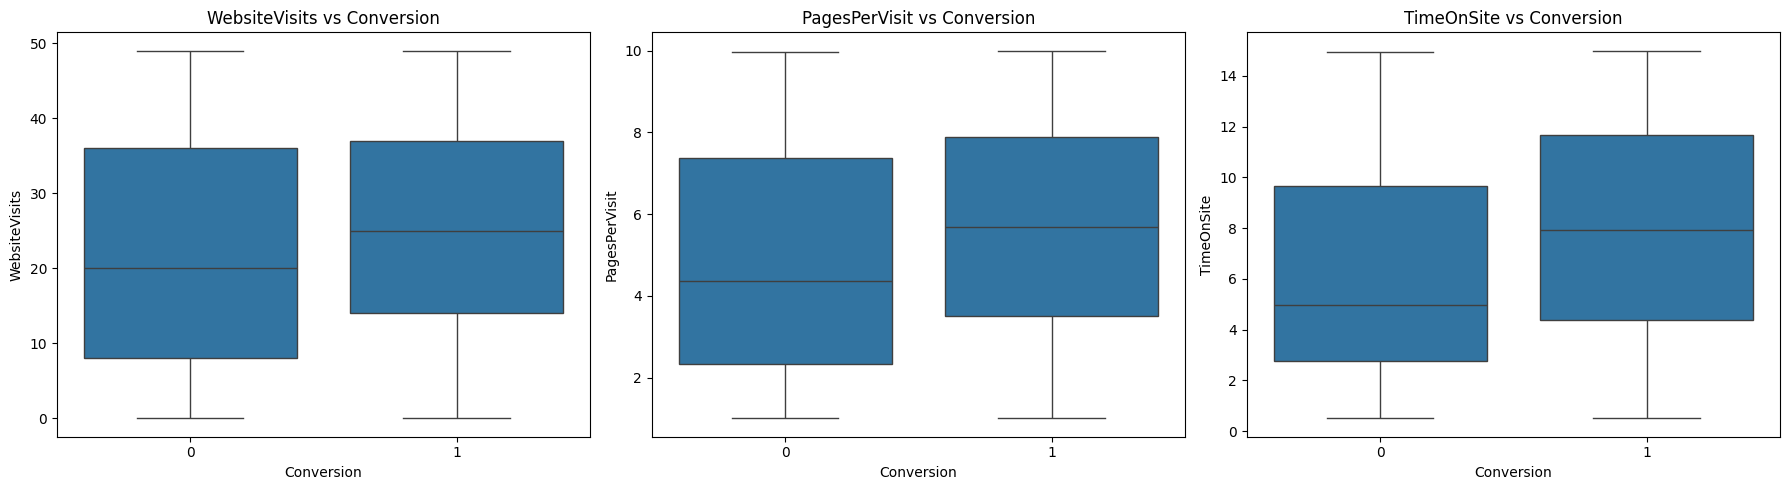

In [12]:
engagement = ['WebsiteVisits', 'PagesPerVisit', 'TimeOnSite']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(engagement):
    sns.boxplot(x='Conversion', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Conversion')

plt.tight_layout()
plt.show()

# Email remains a reliable engagement channel — those who interact via email are more likely to convert. → Combine this with campaign timing or loyalty metrics for stronger predictive power



WebsiteVisits: Converters and non-converters have similar numbers of website visits

PagesPerVisit: Converters view slightly more pages per visit

TimeOnSite: Converters spend more time on the website

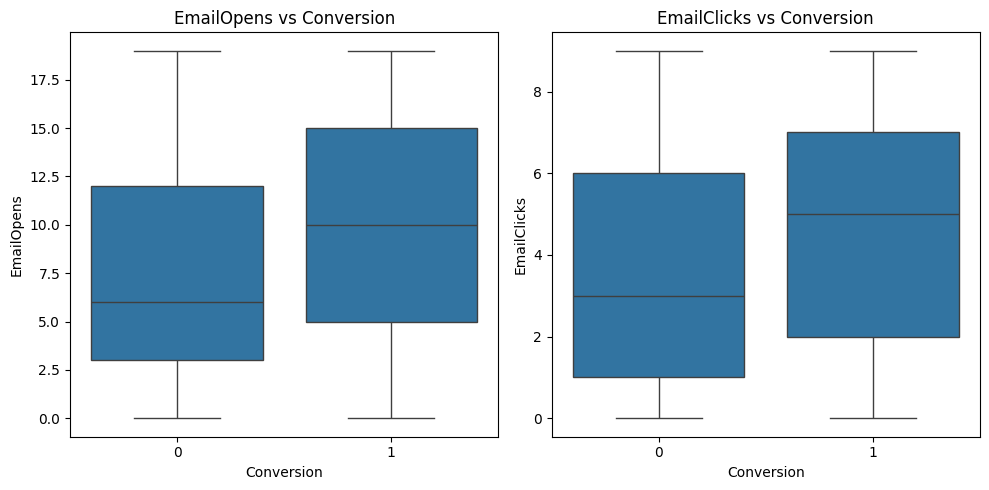

In [13]:
email_cols = ['EmailOpens', 'EmailClicks']

fig, axes = plt.subplots(1, 2, figsize= (10, 5))

for i, col in enumerate(email_cols):
    sns.boxplot(x = 'Conversion', y = col, data = df, ax = axes[i])
    axes[i].set_title(f'{col} vs Conversion')

plt.tight_layout()
plt.show()

# Email remains a reliable engagement channel — those who interact via email are more likely to convert. → Combine this with campaign timing or loyalty metrics for stronger predictive power

Converters open more emails and click more links within emails compared to non-converters.

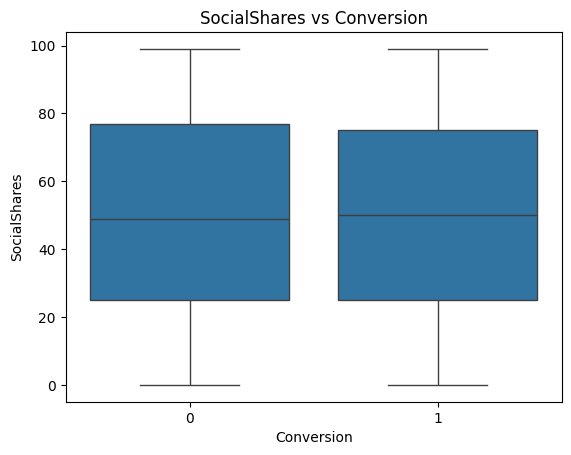

In [14]:
sns.boxplot(x = 'Conversion', y = 'SocialShares', data = df)
plt.title('SocialShares vs Conversion')
plt.show()

# converters and non-converters share roughly equal social activity.
# no visible separation → Social sharing doesn’t predict conversion well

Social sharing activity is identical between converters and non-converters.

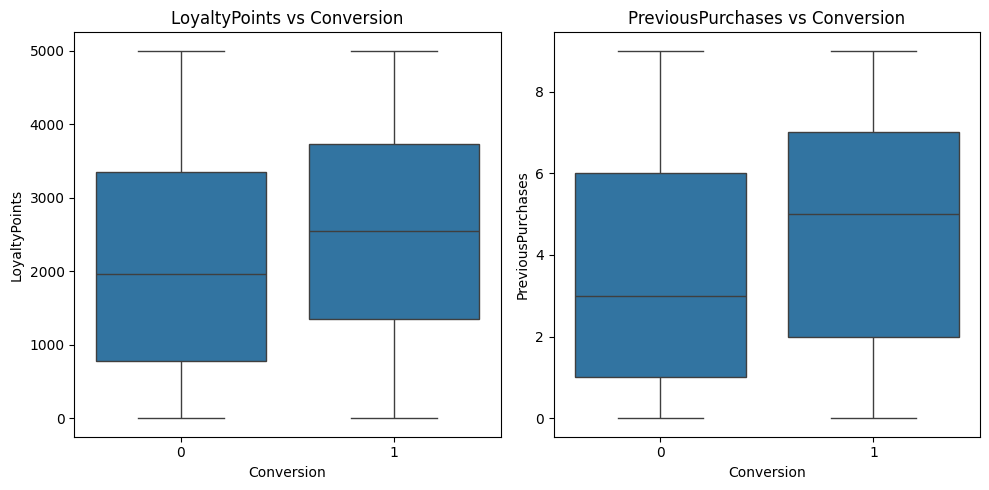

In [15]:
customer_history_cols = ['LoyaltyPoints', 'PreviousPurchases']

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

for i, cols in enumerate(customer_history_cols):
    sns.boxplot(data = df,
                x = 'Conversion',
                y = cols,
                ax = axes[i])
    axes[i].set_title(f'{cols} vs Conversion')

plt.tight_layout()
plt.show()


LoyaltyPoints (left panel): Shows converters with higher median loyalty points, with the converter box shifted upward

PreviousPurchases (right panel): Shows converters with more prior purchases, again with upward-shifted box

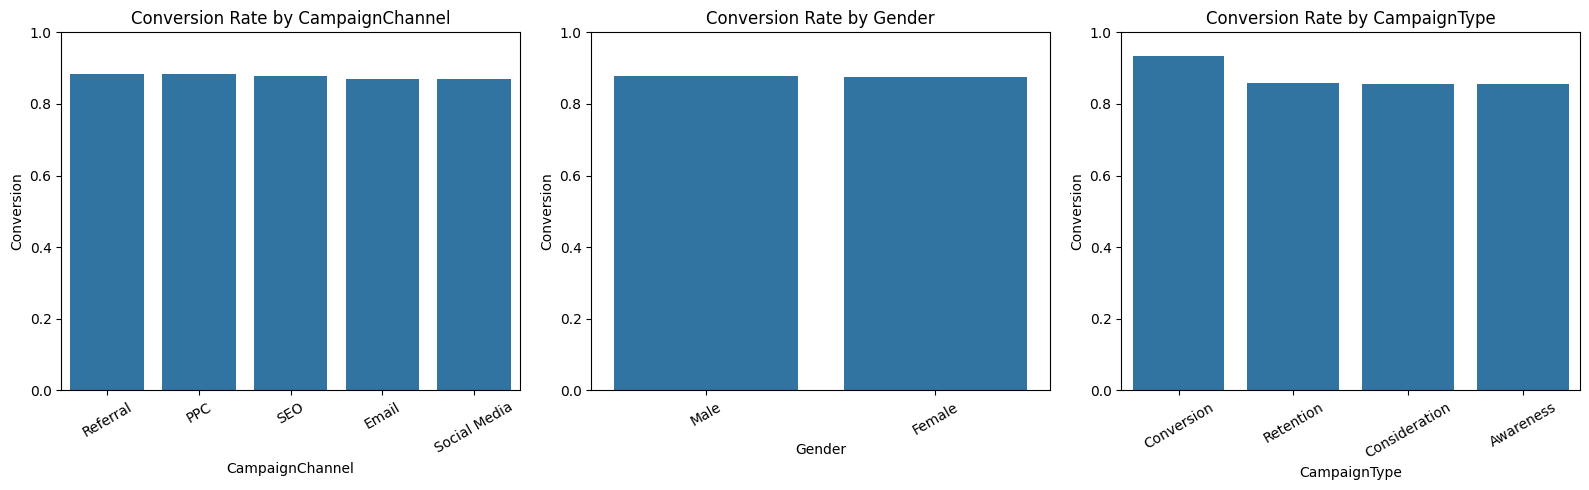

In [16]:
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(16,5))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    rates = df.groupby(col)['Conversion'].mean().sort_values(ascending=False).reset_index()
    sns.barplot(x=col, y='Conversion', data=rates, ax=axes[i])
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f'Conversion Rate by {col}')
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


By Channel: Conversion rates are similar across all channels (Referral, PPC, SEO, Email, Social Media), ranging approximately 87-90%

By Gender: Male and female conversion rates are approximately equal at ~89%

By Campaign Type: Conversion campaigns have the highest rate (~94%), followed by Retention, Consideration, and Awareness campaigns (~85-87%)

<Axes: >

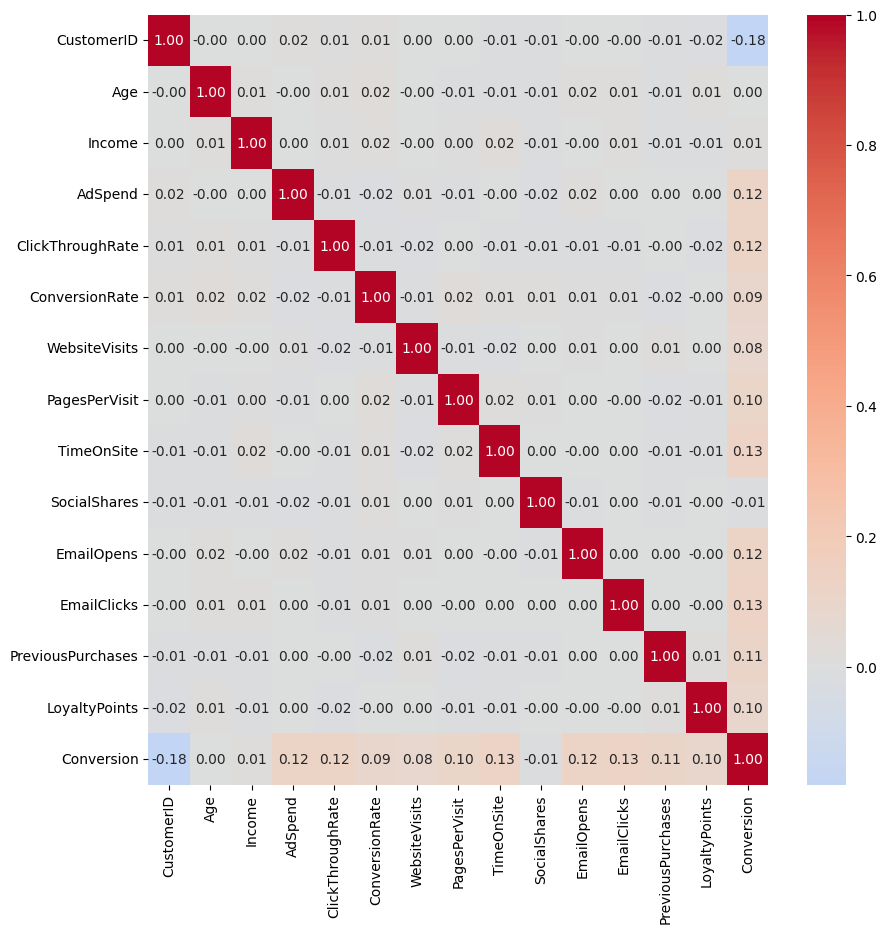

In [17]:
plt.figure(figsize= (10, 10))
sns.heatmap(df.corr(numeric_only= True), annot= True, cmap = 'coolwarm', center= 0, fmt = '.2f')

In [18]:
df['Conversion'].value_counts(normalize= True)

# holds true that conversion is indeed heavily imbalanced 

Conversion
1    0.8765
0    0.1235
Name: proportion, dtype: float64

In [19]:
channel_map = {'Referral' : 0,      
'PPC': 1,    
'Email': 2,  
'SEO' : 3,            
'Social Media': 4
}

df['CampaignChannel'] = df['CampaignChannel'].map(channel_map)


CampaignChannel
Referral        0
PPC             1
Email           2
SEO             3
Social Media    4

Model

In [20]:
# Based on the analysis from above: columns to be determined are: 

cols_to_drop = ['CustomerID', 'ConversionRate', 'CampaignType', 'SocialShares', 'Conversion', 'Gender', 'AdvertisingPlatform', 'AdvertisingTool']

X = df.drop(columns= cols_to_drop)
y = df['Conversion']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 2)

In [22]:
scaler = RobustScaler()
numeric_cols = ['Age', 'Income', 'AdSpend', 'ClickThroughRate',
                'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite',
                'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints']

X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

X_train_scaled_df = X_train.copy()
X_test_scaled_df  = X_test.copy()


X_train_scaled_df[numeric_cols] = X_train_scaled
X_test_scaled_df[numeric_cols]  = X_test_scaled


In [23]:
models = {
    'Logistic Regression':{
        'model': LogisticRegression (random_state= 2),
        'params':{
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'class_weight':['balanced', {0:1, 1:3}, {0:1, 1:4}]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state= 2),
        'params':{
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [5, 10],
            'class_weight': [None, 'balanced', 'balanced_subsample']
        }
    },
    'SVC':{
        'model': SVC(random_state = 2),
        'params':{
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'class_weight': ['balanced']
        }
    },
    'XGBoost':{
        'model': XGBClassifier(random_state = 2),
        'params':{
            'max_depth': [2, 3],
            'learning_rate': [0.01, 0.05],
            'min_child_weight': [5, 10],
            'subsample': [0.6, 0.7],
            'n_estimators': [100, 200],
            'reg_alpha': [0.1, 1],
            'reg_lambda': [1, 2]
        }
    },
    'LightGBM':{
        'model': LGBMClassifier(random_state=2),
        'params':{
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_child_samples': [20, 30],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'class_weight': ['balanced']
        }
    },
    'CatBoost':{
        'model': CatBoostClassifier(random_state= 2, verbose= 0, allow_writing_files= False),
        'params':{
            'iterations': [200, 300],
            'learning_rate': [0.01, 0.05],
            'depth': [4, 6],
            'l2_leaf_reg': [3, 5, 10],
            'border_count': [32, 64],
            'auto_class_weights': ['Balanced'],
            'early_stopping_rounds': [50]
        }
    }
}

In [24]:
results = {}
all_models = {}

for name, config in models.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv = 5,
        n_jobs = -1,
        scoring = 'f1',
        verbose = 1
    )

    grid_search.fit(X_train_scaled_df, y_train)
    all_models[name] = grid_search.best_estimator_

    train_pred = grid_search.best_estimator_.predict(X_train_scaled_df)
    test_pred = grid_search.best_estimator_.predict(X_test_scaled_df)

    results[name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'Train F1': f1_score(y_train, train_pred),
        'Test F1': f1_score(y_test, test_pred),
        'Precision': precision_score(y_test, test_pred),
        'Recall': precision_score(y_test, test_pred)
    }

best_model_name = max(results.keys(), key = lambda x: results[x]['Test F1'])
best_model = results[best_model_name]['best_model']
    

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Info] Number of positive: 5610, number of negative: 790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1677
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [27]:
summary_data = []

for name, result in results.items():
    summary_data.append({
        'Model': name,
        'Train F1': result['Train F1'],
        'Test F1': result['Test F1'],
        'Overfit Gap': result['Train F1'] - result['Test F1'],
        'Precision': result['Precision'],
        'Recall': result['Recall']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test F1', ascending = False)
summary_df = summary_df.round(4)
display(summary_df)

,Model,Train F1,Test F1,Overfit Gap,Precision,Recall
3,XGBoost,0.9569,0.9489,0.0080,0.9086,0.9086
1,Random Forest,0.9482,0.9400,0.0082,0.8873,0.8873
0,Logistic Regression,0.9352,0.9346,0.0006,0.8778,0.8778
4,LightGBM,0.9954,0.9304,0.0650,0.9258,0.9258
5,CatBoost,0.9569,0.9109,0.0460,0.9374,0.9374
2,SVC,0.9142,0.8839,0.0303,0.9306,0.9306


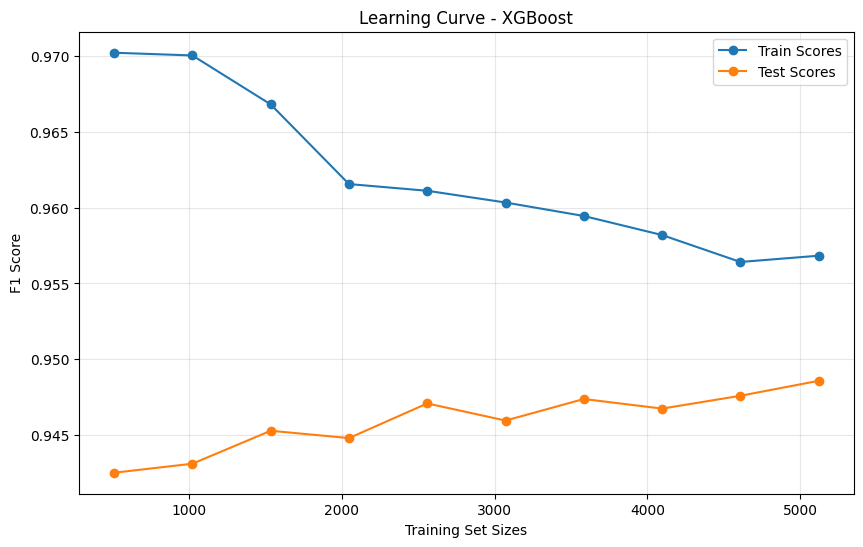

In [30]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train_scaled_df, y_train,
    cv = 5,
    scoring = 'f1',
    train_sizes = np.linspace(0.1, 1.0, 10),
    n_jobs = -1
)

plt.figure(figsize = (10,6))
plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'Train Scores', marker = 'o')
plt.plot(train_sizes, test_scores.mean(axis = 1), label = 'Test Scores', marker = 'o')
plt.xlabel('Training Set Sizes')
plt.ylabel('F1 Score')
plt.title(f'Learning Curve - {best_model_name}')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

In [31]:
cv_scores = cross_val_score(
    best_model,
    X_train_scaled_df, y_train,
    cv = 5,
    scoring = 'f1'
)

print(f'CV F1 Scores: {cv_scores}')
print(f'Mean: {cv_scores.mean(): .3f}')
print(f'Std: {cv_scores.std(): 3f}')

CV F1 Scores: [0.94921041 0.94952951 0.94768184 0.94498934 0.95111492]
Mean:  0.949
Std:  0.002069


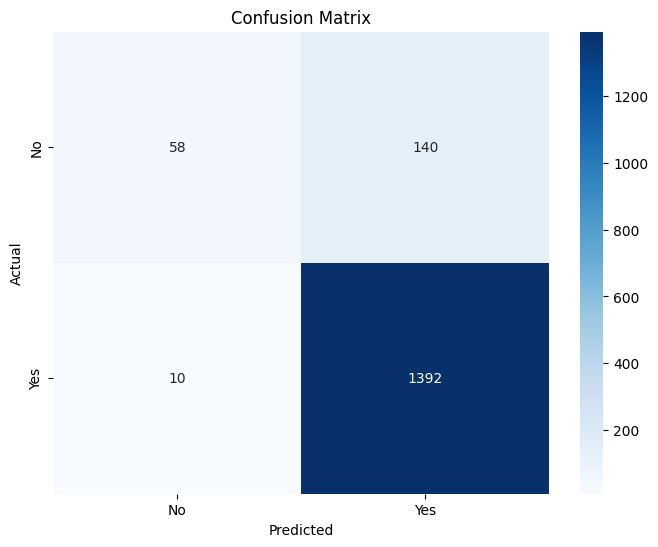

In [32]:
y_pred = best_model.predict(X_test_scaled_df)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize= (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels= ['No', 'Yes'],
            yticklabels= ['No', 'Yes'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()